In [68]:
%matplotlib inline
import math

import numpy as np
import matplotlib.pyplot as plt

from linalg_helper import *

# System Generation

First, we'll simulate a system with lots of dimensions, some unstable eigenvalue and all others stable

In [97]:
dim = 1000
A = make_random_diagonal_matrix(dim, 1, 0.5, 1)
print('Eigenvalues of matrix')
for i in range(dim):
    print(A[i, i])

Eigenvalues of matrix
1.0694411785022366
0.6174840788782171
0.27375284612920586
0.1333212751586728
0.08770761521589711
0.02915809865778573
0.01751388107485814
0.008801109735162993
0.003691426394138337
0.0014532298342871688
0.0010441861740366877
0.00031330172560500944
0.00026371261492475905
0.00011898324526800085
6.230406075855747e-05
4.005500993601064e-05
6.362614291676035e-06
8.362200089508107e-06
2.024136367855601e-06
1.5281191681569661e-06
1.0686091650476034e-06
4.611901313514807e-07
2.832398846764853e-07
1.6486926652330506e-07
6.448594806558648e-08
2.2825552501951402e-08
1.647760412300435e-08
2.8750704681328647e-09
4.443335506389052e-09
2.0921204994697484e-09
8.651023521026224e-10
2.984649491270564e-10
2.859375696166426e-10
1.1539664284636308e-10
4.476664822238091e-11
3.5758627590658647e-11
1.9533981413705297e-11
1.0948875402825507e-11
3.655095998859148e-12
2.743451550885589e-12
1.1227809735215527e-12
6.530891477612287e-13
3.1923912874964613e-13
8.47943023842751e-14
6.2167378751915

In [98]:
C = make_random_subspace(dim, dim)
x_init = make_random_direction(dim)
x = simulate_free_response(A, 20, x_init)
x_obs = (C.dot(x.T)).T
#print('\nActual states')
#plot_state_trace(x)
#print('Observed through matrix')
#plot_state_trace(x_obs)

Given random rotation/unitary transform of the state (random unitary C matrix), all outputs will seem to diverge, or begin exhibiting the diverging eigenvalue. Another thing to look at later, when we start doing control, is if we get similar qualitative results/equivalency by simulating with random eigenvectors vs. some randomly rotated actuation vector.

In [99]:
# Make the random unknown matrix of eigenvectors
Q = make_random_subspace(dim, dim)

In [100]:
# Set how many time steps we want to simulate the system for
N = 500
# Compute the random A matrix for which we don't know the eigenvalues or eigenvectors
A_bar = Q @ A @ Q.T

# Simulate and plot the state evolution without input for a short time and a long time
x1 = simulate_free_response(A_bar, 20, x_init)
#plot_state_trace(x1)
x2 = simulate_free_response(A_bar, N, x_init)
#plot_state_trace(x2)

Dominating behavior of largest eigenvalue doesn't show up until after a while in the unstable system. Does seem to show up with ~k*dim steps.

Having one coordinate transform (Q) in between our random observation direction of the state and just observing it in the diagonalized form doesn't seem all that different. Is it?

# Looking at random projections of the state

In [113]:
trials = 1000
obs_vecs = np.zeros([N*trials, dim])

for i in range(N*trials):
    obs_vecs[i,:] = make_random_direction(dim).reshape([1, dim])

In [114]:
obs = np.zeros([N, 0])

for i in range(trials):
    obs_curr = obs_vecs[N*i:N*(i+1), :]
    obs_vec = np.abs(np.einsum('ij,ij->i', obs_curr, x2))
    obs = np.hstack((obs, obs_vec.reshape([N, 1])))

Text(0.5,1,'Absolute value of projections with eigenvalue envelope and eigenvector projections of state')

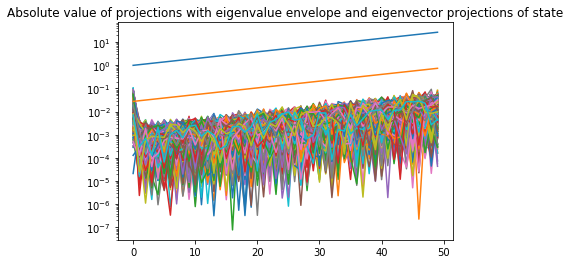

In [115]:
t_final = N//10
eig = max(np.diagonal(A))
lambda_vec = np.array([(eig ** n) for n in range(t_final)])
for i in range(trials):
    plt.plot(range(t_final), obs[0:t_final, i])
# eigenvalue power envelope
plt.plot(range(t_final), lambda_vec)
# projections of state to the largest eigenvector
plt.plot(range(t_final), abs(x2[0:t_final,:].dot(Q[:,0])))
plt.yscale('log')
plt.title('Absolute value of projections with eigenvalue envelope and eigenvector projections of state')

Question: Why do the observations display a trend mostly aligned with the eigenvector even if we're mostly orthogonal (Based on the histogram below)? How does the variance of the projections change with dimensionality?

Text(0.5,1,'Histogram of largest eigenvector dotted with observation vectors')

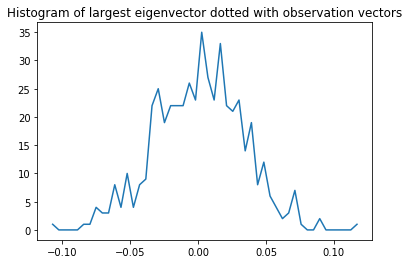

In [116]:
# Find largest eigenvalue and corresponding eigenvector
max_eig_index = max(zip(range(dim), np.diagonal(A)), key=lambda x: x[1])[0]
max_eigvec = Q[:,max_eig_index].reshape([dim, 1])

dots_big_eigvec = obs_vecs[0:N,:].dot(max_eigvec)
hist0, edges0 = np.histogram(dots_big_eigvec, N//10)
edge_means0 = [(edges0[i] + edges0[i+1])/2 for i in range(len(edges0) -1)]
plt.plot(edge_means0, hist0)
plt.title('Histogram of largest eigenvector dotted with observation vectors')

Is the envelope of our observations of interest? Yes! (empirircally so) There's something happening here, but maybe there's a really simple straightforward explanation. Maybe it's that since the largest state is the one blowing up, the observation vectors that give the maximal dot products on the fringe/envelope will be in greatest alignment with the blowing up eigenvector? So if we can isolate the envelope somehow (look to make the variation convex)

Based on the histogram above, it seems like it's not actually the case that we even get close to being in alignment with the eigenvector, but we still get the trend anyway. That's weird.

It looks like it's possible to under estimate the eigenvalue based on some part of the dot products. For now, maybe try to convexify (move all points that are lower in the middle of a set of 3 to the average of the 2 points on the exterior) Additionally, would orthogonalization help at all? (Since after n observations due to probabalistic orthogonality, we're bound to be able to write all subsequent measurements in terms of a basis - not necessarily orthogonal?)

Can we look at with k largest eigenvalues, if we can see piece wise linearity based on initial conditions and certain eigenvalues dominating others in the short time span as they grow?

Why is the envelope sometimes exceeded? Is this a shift/translation in log/multiply in normal scale, or is this something more fundamental? Does this interfere with upper bounds?

## "Smoothing" by maximums

The code below looks to see if smoothing would be more useful for finding the eigenvalue. The hope is to make an linear envelope in the semilog scale by somehow "convexifying" the projection trend.

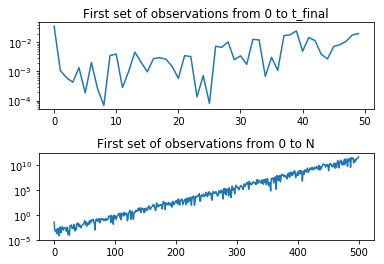

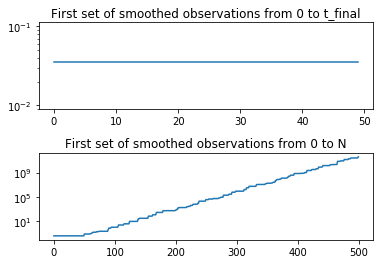

In [117]:
obs1 = np.array(obs[:,0])

fig, ax = plt.subplots(2)
ax[0].plot(range(t_final), obs1[0:t_final])
ax[0].set_yscale('log')
ax[0].set_title('First set of observations from 0 to t_final')
ax[1].plot(range(N), obs1)
ax[1].set_yscale('log')
ax[1].set_title('First set of observations from 0 to N')
fig.subplots_adjust(hspace=0.5)

for i in range(N-1):
    if obs1[i+1] < obs1[i]:
        obs1[i+1] = obs1[i]

fig, ax = plt.subplots(2)
ax[0].plot(range(t_final), obs1[0:t_final])
ax[0].set_yscale('log')
ax[0].set_title('First set of smoothed observations from 0 to t_final')
ax[1].plot(range(N), obs1)
ax[1].set_yscale('log')
ax[1].set_title('First set of smoothed observations from 0 to N')
fig.subplots_adjust(hspace=0.5)

# Just try regression on the unsmoothed projections to get the eigenvalue

For many trials, compute the slope (by a linear regression), then look at the distribution of the slopes for different sets of observations to see if the eigenvalue is roughly distributed about the maximum.

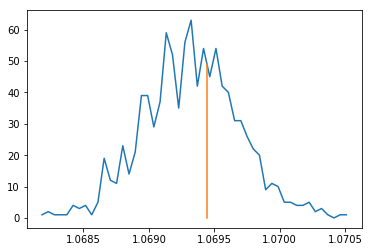

In [118]:
time = np.array(range(N)).reshape([N, 1])
A_regress = np.hstack((time, np.ones([N, 1])))

r_result = np.zeros([trials, 2])

for i in range(trials):
    b_regress = np.log(np.array(obs[:,i]).reshape([N, 1]))
    slope, _, _, _ = np.linalg.lstsq(A_regress, b_regress, rcond=None)
    r_result[i,:] = slope.reshape([1, 2])
    
hist, edges = np.histogram(np.exp(r_result[:,0]), N//10)

edge_means = [(edges[i] + edges[i+1])/2 for i in range(len(edges) -1)]

plt.plot(edge_means, hist)
plt.plot([eig]*50,range(50))
plt.title('Eigenvalue regression d')

Does dimensionality seems to affect variance? Additionally, initial condition/shift affects the mean of the regression distribution.

In [119]:
# I don't think this code works, but not because of errors in the code, but because of a conceptual stop.
eig_vec_result = np.zeros([trials, dim])

fit_num = 10

for i in range(fit_num):
    d_s = obs_vecs[N*i:N*(i+1), :]
    for j in range(N):
        d_s[j, :] = d_s[j, :] * (np.exp(r_result[i,0]) ** j)
    vec_result , _, _, _ = np.linalg.lstsq(d_s, abs(obs[:,i]), rcond=None)
    eig_vec_result[i, :] = vec_result.reshape([1, dim])/np.linalg.norm(vec_result)